In [1]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

# %pip install torch==1.8.0+cpu torchvision==0.9.0+cpu -f https://download.pytorch.org/whl/torch_stable.html
# %pip install timm==0.3.2 six


from __future__ import print_function, division
from ConvNeXt.convnext_isotropic import convnext_isotropic_small
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.tensorboard import SummaryWriter
import datetime
import re

plt.ion()   # interactive mode

#### These are all helper function . .  Check the last two block for the content.

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
        'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

from torch.utils.data import Dataset, DataLoader
import cv2
    

In [3]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, fineTune = False, dataName=None):
    if fineTune:
        _type = '_FineTune_' + dataName
    else:
        _type = '_FeatureExtractor_' + dataName
        
        
    since = time.time()
    writer = SummaryWriter(log_dir="./runs/FeatureExtractTL/"+re.sub(r'\W+', '', model._get_name()+ _type + datetime.datetime.now().strftime("%Y-%m-%d%H:%M:%S")))
    # writer = SummaryWriter(log_dir="./runs/")

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            writer.add_scalar('Loss/'+ phase, epoch_loss, epoch)
            # writer.add_scalar('Loss/test', np.random.random(), n_iter)
            writer.add_scalar('Accuracy/'+ phase, epoch_acc, epoch)
            # writer.add_scalar('Accuracy/test', np.random.random(), n_iter)
            writer.add_scalar('Time/'+ phase, time.time() - since, epoch)
    
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## transfer learning (feature extraction) on data_dog_cat

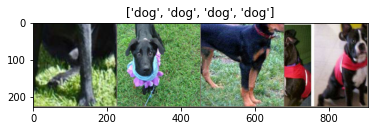

Epoch 0/24
----------
train Loss: 0.4071 Acc: 0.8564
valid Loss: 0.2237 Acc: 0.9709

Epoch 1/24
----------
train Loss: 0.1539 Acc: 0.9851
valid Loss: 0.1409 Acc: 0.9806

Epoch 2/24
----------
train Loss: 0.1117 Acc: 0.9901
valid Loss: 0.1111 Acc: 0.9806

Epoch 3/24
----------
train Loss: 0.1099 Acc: 0.9802
valid Loss: 0.0973 Acc: 0.9806

Epoch 4/24
----------
train Loss: 0.0843 Acc: 0.9802
valid Loss: 0.0866 Acc: 0.9806

Epoch 5/24
----------
train Loss: 0.0667 Acc: 0.9901
valid Loss: 0.0810 Acc: 0.9806

Epoch 6/24
----------
train Loss: 0.0507 Acc: 0.9950
valid Loss: 0.0770 Acc: 0.9806

Epoch 7/24
----------
train Loss: 0.0777 Acc: 0.9802
valid Loss: 0.0767 Acc: 0.9806

Epoch 8/24
----------
train Loss: 0.0636 Acc: 0.9950
valid Loss: 0.0764 Acc: 0.9806

Epoch 9/24
----------
train Loss: 0.0561 Acc: 0.9851
valid Loss: 0.0760 Acc: 0.9806

Epoch 10/24
----------
train Loss: 0.0547 Acc: 0.9851
valid Loss: 0.0756 Acc: 0.9806

Epoch 11/24
----------
train Loss: 0.0592 Acc: 0.9851
valid Loss

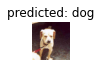

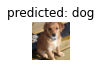

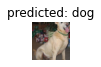

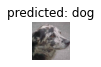

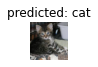

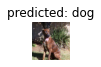

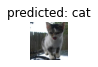

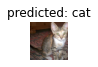

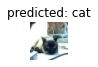

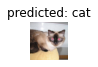

In [7]:
data_dir = './data_dog_cat/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test', 'valid']}



dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train','test', 'valid']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train','test', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])



fineTune = False   # feature Extractor if False

# model_conv = models.resnet18(pretrained=True)
model_conv  = convnext_isotropic_small(pretrained=True,)

for param in model_conv.parameters():
    param.requires_grad = False

# model_conv.fc = nn.Linear(model_conv.fc.in_features, 2)
model_conv.head = nn.Linear(model_conv.head.in_features , 2)

model_ft = model_conv .to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_conv  = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25, fineTune= fineTune, dataName= data_dir)

visualize_model(model_conv , num_images=10)

In [8]:
model_conv.eval()
running_loss = 0.0
running_corrects = 0

for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    # forward
    # track history if only in train
    with torch.set_grad_enabled(False):
        outputs = model_conv(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
    # statistics
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

_epoch_loss = running_loss / dataset_sizes['test']
_epoch_acc = running_corrects.double() / dataset_sizes['test']

print("## transfer learning (feature extraction) on data_dog_cat")
print("test loss: ", _epoch_loss, " test acc: ", _epoch_acc)

## transfer learning (feature extraction) on data_dog_cat
test loss:  0.1133983799580592  test acc:  tensor(0.9889, device='cuda:0', dtype=torch.float64)


## transfer learning (Fine Tune) on data_sign_language

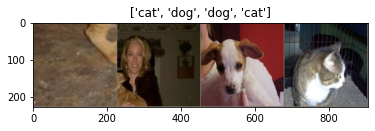

Epoch 0/24
----------
train Loss: 0.3898 Acc: 0.8416
valid Loss: 0.1501 Acc: 0.9806

Epoch 1/24
----------
train Loss: 0.1204 Acc: 0.9752
valid Loss: 0.0760 Acc: 0.9903

Epoch 2/24
----------
train Loss: 0.0736 Acc: 0.9851
valid Loss: 0.0611 Acc: 0.9903

Epoch 3/24
----------
train Loss: 0.0555 Acc: 0.9901
valid Loss: 0.0659 Acc: 0.9806

Epoch 4/24
----------
train Loss: 0.0286 Acc: 1.0000
valid Loss: 0.0439 Acc: 0.9903

Epoch 5/24
----------
train Loss: 0.0510 Acc: 0.9802
valid Loss: 0.0360 Acc: 0.9903

Epoch 6/24
----------
train Loss: 0.0477 Acc: 0.9851
valid Loss: 0.0553 Acc: 0.9709

Epoch 7/24
----------
train Loss: 0.0369 Acc: 0.9901
valid Loss: 0.0519 Acc: 0.9806

Epoch 8/24
----------
train Loss: 0.0512 Acc: 0.9802
valid Loss: 0.0416 Acc: 0.9806

Epoch 9/24
----------
train Loss: 0.0430 Acc: 0.9851
valid Loss: 0.0406 Acc: 0.9806

Epoch 10/24
----------
train Loss: 0.0353 Acc: 0.9950
valid Loss: 0.0409 Acc: 0.9806

Epoch 11/24
----------
train Loss: 0.0275 Acc: 0.9901
valid Loss

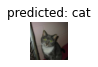

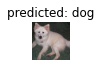

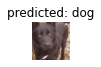

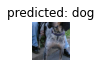

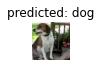

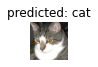

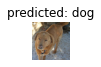

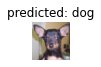

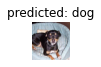

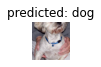

In [11]:
data_dir = './data_dog_cat/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test', 'valid']}



dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train','test', 'valid']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train','test', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])



fineTune = True   # feature Extractor if False

# model_conv = models.resnet18(pretrained=True)
model_conv  = convnext_isotropic_small(pretrained=True,)


# model_conv.fc = nn.Linear(model_conv.fc.in_features, 2)
model_conv.head = nn.Linear(model_conv.head.in_features , 2)

model_ft = model_conv .to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_conv  = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25, fineTune= fineTune, dataName= data_dir)

visualize_model(model_conv , num_images=10)

In [12]:
model_conv.eval()
running_loss = 0.0
running_corrects = 0

for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    # forward
    # track history if only in train
    with torch.set_grad_enabled(False):
        outputs = model_conv(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
    # statistics
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

_epoch_loss = running_loss / dataset_sizes['test']
_epoch_acc = running_corrects.double() / dataset_sizes['test']

print("transfer learning (Fine Tune) on data_sign_language")
print("test loss: ", _epoch_loss, " test acc: ", _epoch_acc)

transfer learning (Fine Tune) on data_sign_language
test loss:  0.06270768305497397  test acc:  tensor(0.9933, device='cuda:0', dtype=torch.float64)



##
####
Hint:  
Use Images in train/ folder for training, val/ folder for validation and test/ folder for testing. 

Load External data in colab https://colab.research.google.com/notebooks/io.ipynb 

 

#### You are free to choose any reasonable model pre-trained in ImageNet. Comment upon your choice. 
I chose https://github.com/facebookresearch/ConvNeXt as is the SOTA and the best model for transfer learning.
It even could beat the best transformer model for transfer learning in ImageNet like Vit.
 

#### Write your own custom data loader for PyTorch. 
I used the torchvision.datasets.ImageFolder class.

 

#### Discuss about the optimization and parameters you have chosen. Comment on the learning rate you have selected for both cases. 
I chose stochastic gradient descent (optionally with momentum) and the learning rate of 0.001 for both cases.
I used epoch of 25 for both cases.
 

#### Discuss the transfer learning approaches you have chosen for both cases.. 
I chosefeature extraction with ConvNeXt  pretrained model and fine tuning with the same model.